In [1]:
from eeg_learn_functions import *

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
from numpy import genfromtxt

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [3]:
delta = (0.1, 4)
theta = (4,8)
alpha = (8,14)
beta = (14,30)
gamma = (30, 50)

In [4]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
#f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [5]:
def theta_alpha_beta_averages(f,Y):
    delta_range = (0.1, 4)
    theta_range = (4,8)
    alpha_range = (8,14)
    beta_range = (14,30)
    gamma_range = (30, 50)
    delta = Y[(f>delta_range[0]) & (f<=delta_range[1])].mean()
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    gamma = Y[(f>gamma_range[0]) & (f<=gamma_range[1])].mean()

    return delta, theta, alpha, beta, gamma

In [6]:
def make_steps(samples,frame_duration,overlap):
    '''
    in:
    samples - number of samples in the session
    frame_duration - frame duration in seconds 
    overlap - float fraction of frame to overlap in range (0,1)
    
    out: list of tuple ranges
    '''
    #steps = np.arange(0,len(df),frame_length)
    Fs = 128.0
    i = 0
    intervals = []
    samples_per_frame = 100#Fs * frame_duration
    while i+samples_per_frame <= samples:
        intervals.append((i,i+samples_per_frame))
        i = i + samples_per_frame - int(samples_per_frame*overlap)
    return intervals

In [7]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = 100#Fs*frame_duration
    frames = []
    steps = make_steps(len(df),frame_duration,overlap)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.loc[steps[i][0]:steps[i][1],int(channel)])
                f,Y =  get_fft(snippet)
                delta, theta, alpha, beta, gamma = theta_alpha_beta_averages(f,Y)
                frame.append([delta, theta, alpha, beta, gamma])
            
        frames.append(frame)
    return np.array(frames)

In [8]:
locs_2d = [(-2.0,4.0),
           (2.0,4.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [9]:
from sklearn.preprocessing import StandardScaler
import pickle
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap, normalize = False):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    ##################################
    ###Still need to do the overlap###!!!
    ##################################
    
    Fs = 128.0   #sampling rate
    frame_length = 100#Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        data = genfromtxt(file, delimiter=',')
        df = pd.DataFrame(data)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*5)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
    print(X.shape)
    if(normalize):
        scalers = [StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()]
        scalers[0] = scalers[0].fit(X[:,:,:,0].reshape((X.shape[0]*image_size, image_size)))
        scalers[1] = scalers[1].fit(X[:,:,:,1].reshape((X.shape[0]*image_size, image_size)))
        scalers[2] = scalers[2].fit(X[:,:,:,2].reshape((X.shape[0]*image_size, image_size)))
        scalers[3] = scalers[3].fit(X[:,:,:,3].reshape((X.shape[0]*image_size, image_size)))
        scalers[4] = scalers[4].fit(X[:,:,:,4].reshape((X.shape[0]*image_size, image_size)))

        X_r = scalers[0].transform(X[:,:,:,0].reshape((X.shape[0]*image_size, image_size)))
        X_g = scalers[0].transform(X[:,:,:,1].reshape((X.shape[0]*image_size, image_size)))
        X_b = scalers[0].transform(X[:,:,:,2].reshape((X.shape[0]*image_size, image_size)))
        X_x = scalers[0].transform(X[:,:,:,3].reshape((X.shape[0]*image_size, image_size)))
        X_y = scalers[0].transform(X[:,:,:,4].reshape((X.shape[0]*image_size, image_size)))
        #
        X[:,:,:,0] = X_r.reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,1] = X_g.reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,2] = X_b.reshape((X.shape[0], X.shape[1], X.shape[2]))   
        X[:,:,:,3] = X_x.reshape((X.shape[0], X.shape[1], X.shape[2])) 
        X[:,:,:,4] = X_y.reshape((X.shape[0], X.shape[1], X.shape[2])) 
    
        with open('scalers_dump.pickle', 'wb') as f:
            pickle.dump(scalers, f)
    return X,np.array(y)

In [10]:
file_names = ['data/data_train_new_appr_1_label1.csv',
              'data/data_train_new_appr_2_label0.csv',
              'data/data_train_new_appr_3_label1.csv',
              'data/data_train_new_appr_4_label0.csv',
              'data/data_train_new_appr_7_label0.csv',
              'data/data_train_new_appr_8_label1.csv']
labels = [1,0,1,0, 0,1]
image_size = 28
frame_duration = 0.78
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

Generating training data...
Processing session:  data/data_train_new_appr_1_label1.csv . ( 1  of  6 )
398  frames generated with label  1 .398Interpolating 49/398Interpolating 73/398Interpolating 98/398Interpolating 123/398Interpolating 147/398Interpolating 170/398Interpolating 194/398Interpolating 218/398Interpolating 241/398Interpolating 266/398Interpolating 290/398Interpolating 313/398Interpolating 338/398Interpolating 362/398Interpolating 386/398


Processing session:  data/data_train_new_appr_2_label0.csv . ( 2  of  6 )
398  frames generated with label  0 .398Interpolating 44/398Interpolating 67/398Interpolating 88/398Interpolating 112/398Interpolating 137/398Interpolating 161/398Interpolating 185/398Interpolating 211/398Interpolating 235/398Interpolating 258/398Interpolating 281/398Interpolating 305/398Interpolating 330/398Interpolating 354/398Interpolating 378/398


Processing session:  data/data_train_new_appr_3_label1.csv . ( 3  of  6 )
398  frames generated with label  1 .398

In [55]:
X.shape

(2388, 28, 28, 5)

In [56]:
y.shape

(2388,)

TypeError: Invalid shape (28, 28, 5) for image data

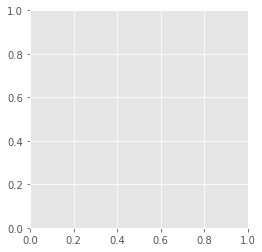

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X[202]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


''

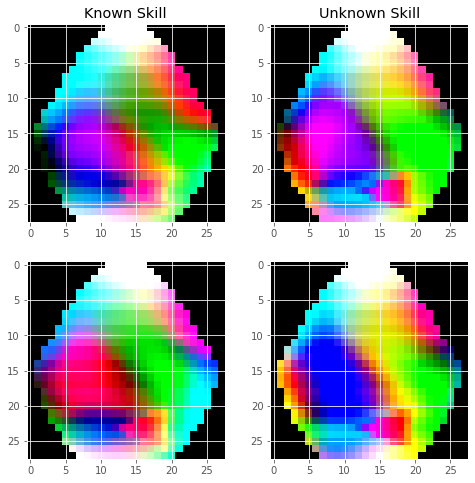

In [99]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2,2, figsize = (8,8))
axarr[0][0].set_title('Known Skill')
axarr[0][0].imshow(X[0])
axarr[1][0].imshow(X[1])

axarr[0][1].set_title('Unknown Skill')
axarr[0][1].imshow(X[1550])
axarr[1][1].imshow(X[1551])

;

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=True)

In [58]:
y_train.shape

(2149,)

In [59]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 5)

x_train shape: (2149, 28, 28, 5)
2149 train samples
239 test samples


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
batch_size = 32
num_classes = 2
epochs = 50

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(10))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_split = 0.05)

model.save('80_model.h5')

Train on 2041 samples, validate on 108 samples
Epoch 1/50
2041/2041 [==============================] - 2s 782us/step - loss: 0.6703 - accuracy: 0.6257 - val_loss: 0.6639 - val_accuracy: 0.6296
Epoch 2/50
2041/2041 [==============================] - 1s 443us/step - loss: 0.6348 - accuracy: 0.6781 - val_loss: 0.6181 - val_accuracy: 0.6944
Epoch 3/50
2041/2041 [==============================] - 1s 427us/step - loss: 0.6071 - accuracy: 0.7026 - val_loss: 0.6121 - val_accuracy: 0.7407
Epoch 4/50
2041/2041 [==============================] - 1s 432us/step - loss: 0.5905 - accuracy: 0.7065 - val_loss: 0.5951 - val_accuracy: 0.6944
Epoch 5/50
2041/2041 [==============================] - 1s 432us/step - loss: 0.5869 - accuracy: 0.7212 - val_loss: 0.6629 - val_accuracy: 0.6574
Epoch 6/50
2041/2041 [==============================] - 1s 432us/step - loss: 0.5781 - accuracy: 0.7158 - val_loss: 0.5894 - val_accuracy: 0.7037
Epoch 7/50
2041/2041 [==============================] - 1s 429us/step - loss:

In [32]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import StratifiedKFold
batch_size = 32
num_classes = 2
epochs = 110

# convert class vectors to binary class matrices

kf = StratifiedKFold(n_splits=5, shuffle = True)
acc_row = []
lst = []
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    #x_train = x_train.astype('float32')
    #x_test = x_test.astype('float32')
    #x_train /= 255
    #x_test /= 255


    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_split = 0.1)
    lst.append(model.evaluate(x_test, y_test))
    print(lst)

Train on 858 samples, validate on 96 samples
Epoch 1/110
858/858 [==============================] - 1s 1ms/step - loss: 0.7998 - accuracy: 0.5839 - val_loss: 0.8496 - val_accuracy: 0.0729
Epoch 2/110
858/858 [==============================] - 0s 469us/step - loss: 0.6555 - accuracy: 0.6399 - val_loss: 0.9700 - val_accuracy: 0.0208
Epoch 3/110
858/858 [==============================] - 0s 452us/step - loss: 0.6439 - accuracy: 0.6515 - val_loss: 0.9361 - val_accuracy: 0.0521
Epoch 4/110
858/858 [==============================] - 0s 453us/step - loss: 0.6367 - accuracy: 0.6725 - val_loss: 0.9556 - val_accuracy: 0.0625
Epoch 5/110
858/858 [==============================] - 0s 451us/step - loss: 0.6267 - accuracy: 0.6515 - val_loss: 1.2293 - val_accuracy: 0.0000e+00
Epoch 6/110
858/858 [==============================] - 0s 447us/step - loss: 0.6252 - accuracy: 0.6678 - val_loss: 1.0852 - val_accuracy: 0.0521
Epoch 7/110
858/858 [==============================] - 0s 447us/step - loss: 0.6201

Epoch 57/110
858/858 [==============================] - 0s 454us/step - loss: 0.4378 - accuracy: 0.8019 - val_loss: 1.5049 - val_accuracy: 0.1771
Epoch 58/110
858/858 [==============================] - 0s 446us/step - loss: 0.4362 - accuracy: 0.8135 - val_loss: 1.2241 - val_accuracy: 0.2708
Epoch 59/110
858/858 [==============================] - 0s 446us/step - loss: 0.4387 - accuracy: 0.8042 - val_loss: 1.4858 - val_accuracy: 0.1667
Epoch 60/110
858/858 [==============================] - 0s 449us/step - loss: 0.4283 - accuracy: 0.8182 - val_loss: 1.4791 - val_accuracy: 0.1562
Epoch 61/110
858/858 [==============================] - 0s 441us/step - loss: 0.4286 - accuracy: 0.8077 - val_loss: 1.3621 - val_accuracy: 0.2500
Epoch 62/110
858/858 [==============================] - 0s 447us/step - loss: 0.4287 - accuracy: 0.8135 - val_loss: 1.3789 - val_accuracy: 0.2083
Epoch 63/110
858/858 [==============================] - 0s 450us/step - loss: 0.4279 - accuracy: 0.8124 - val_loss: 1.3455 -

KeyboardInterrupt: 

In [19]:
model.save('path_to_my_model.h5')

In [52]:
model.evaluate(x_test, y_test)

120/120 [==============================] - 0s 1ms/step


[0.4470618307590485, 0.8083333373069763]

In [53]:
from test_pipeline import  TestPipelineEEG
import pandas as pd
import pickle
import numpy as np
predictor = TestPipelineEEG(image_size = 28, frame_duration = 0.78, overlap = 0.0, model_path = '80_model.h5', normalize = False)
data = pd.read_csv('data/data_train_new_appr_5_label0.csv')
data.columns = range(14)
lst = []
for i in range(200):
    lst.append(predictor.evaluate(data.iloc[i*100:i*100+100]))
print("Accuracy = {}".format(1-np.sum(lst)/len(lst)))

data = pd.read_csv('data/data_train_new_appr_6_label1.csv')
data.columns = range(14)
lst = []
for i in range(200):
    lst.append(predictor.evaluate(data.iloc[i*100:i*100+100]))
print("Accuracy = {}".format(np.sum(lst)/len(lst)))

Accuracy = 0.17500000000000004 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1
Accuracy = 0.6251Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1Interpolating 1/1
